## The genomic regions in question

In `03_compartments.ipynb` we extracted the genomic intervals of A compartments on all cell types in all combinations of the following parameters:

* Cell type: fibroblast, spermatocyte, pachytene spermatocyte, round spermatid, sperm
* Chromosome: X
* E1 restriction: full-chromosome, chromosome arms, 10Mb windows
* Resolution: 100 kb, 500 kb

The following parameter was only changed for 100kb resolution:

* Smoothing: No smoothing, 5 bins (500kb) 

Resulting in **45** .csv files. They are saved to `../results/compartments/`.


### Load the data

In [1]:
import pandas as pd
import os

# Directory containing your .csv files
csv_dir = '../results/compartments/'

# Create a dictionary to store the DataFrames
dataframes = {}

# Iterate over all .csv files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):  # Check for .csv files
        # Construct the full file path
        filepath = os.path.join(csv_dir, filename)
        
        # Load the CSV into a DataFrame
        # Use the filename (without extension) as the dictionary key
        key = filename.replace('_a_comp_coords_', '_')
        key = os.path.splitext(key)[0]
        dataframes[key] = pd.read_csv(filepath)
        dataframes[key]['length'] = dataframes[key]['end'] - dataframes[key]['start']

# The `dataframes` dictionary now contains the DataFrames
dataframes.keys()

ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')
ech90['length'] = ech90['end'] - ech90['start']


## Time to unleash `genominterv` on the .csv files


### Define a plotting function

In [2]:
# Kaspers plotting function
 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

def plot_intervals(query=None, annot=None, **kwargs):

    tups = []
    if query is not None:
        tups.append(('query', query))
    if annot is not None:
        tups.append(('annot', annot))
    tups.extend(kwargs.items())
    tups = reversed(tups)

    df_list = []
    labels = []
    for label, df in tups:
        labels.append(label)
        df['label'] = label
        df_list.append(df)
    bigdf = pd.concat(df_list)

    bigdf['chrom'] = pd.Categorical(bigdf['chrom'], bigdf['chrom'].unique())
    bigdf['label'] = pd.Categorical(bigdf['label'], bigdf['label'].unique())

    gr = bigdf.groupby('chrom', observed=False)
    fig, axes = plt.subplots(gr.ngroups, 1, figsize=(8, 1.5*gr.ngroups), 
                            sharey=True
                            #  sharex=True
                             )
    if type(axes) is not np.ndarray:
        # in case there is only one axis so it not returned as a list
        axes = np.array([axes])
    
    # with plt.style.context(('default')):

    for i, chrom in enumerate(gr.groups):
        _df = gr.get_group(chrom)
        _gr = _df.groupby('label', observed=False)
        for y, label in enumerate(_gr.groups):
            try:
                df = _gr.get_group(label)
            except KeyError:
                continue
            y = np.repeat(y, df.index.size)
            axes[i].hlines(y, df.start.tolist(), df.end.tolist(), alpha=0.5, lw=5, colors=f'C{y[0]}')
            delta = len(labels)/10
            axes[i].vlines(df.start.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')
            axes[i].vlines(df.end.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')

        axes[i].spines['top'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

        axes[i].set_yticks(list(range(len(labels))), labels)
        axes[i].tick_params(axis='y', which='both', left=False)
        axes[i].set_ylim(-1, len(labels)-0.7)
        # axes[i].set_xlim(df.start.min()-delta, df.end.max()+delta)
        if i != gr.ngroups-1:
            axes[i].tick_params(axis='x', which='both', bottom=False)

        axes[i].set_title(chrom, loc='left', fontsize=10)
    plt.tight_layout()

In [3]:
# My plotting function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from genominterv import interval_intersect

%config InlineBackend.figure_format = 'svg'



def plot_regions(query=None, annot=None, intersect=None):
    chrom = annot['chrom'].unique()[0]
    chromsize = pd.read_csv('../data/rheMac10.filtered.chrom.sizes', sep='\t', header=None, names=['chrom', 'size'])
    chromsize = chromsize[chromsize['chrom'] == chrom]['size'].values[0]
    
    # Define the plot
    height = 1 + (1 if query is not None else 0) + (1 if intersect is not None else 0)
    height = height * 0.75

    f, ax = plt.subplots(figsize=(10, height), sharex=True)
    ax.spines[:].set_visible(False)

    # Plot the annot
    # Iterate over each interval in the DataFrame
    for start, end in zip(annot['start'], annot['end']):
        rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:red', linewidth=0, alpha=0.6)
        ax.add_patch(rect)
        ax.spines['bottom'].set_visible(True)
        lbl = annot['label'].unique()[0] if 'label' in annot.columns else 'A-Comp'
        ax.set_ylabel(lbl, rotation=0, fontsize=10, labelpad=30)

    
    divider = make_axes_locatable(ax)

    if query is not None:
        qax = divider.append_axes("top", size="100%", pad=0.2, sharex=ax)
        qax.xaxis.set_visible(False)
        # Plot the query
        for start, end in zip(query['start'], query['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:blue', linewidth=0, alpha=0.6)
            qax.add_patch(rect)
            qax.spines[:].set_visible(False)
            qax.set_yticks([]) 
            qax.set_title(chrom, loc='left', fontsize=10)
            qax.set_ylabel('ECH90', rotation=0, fontsize=10, labelpad=30)
    
    if intersect is not None:
        iax = divider.append_axes("bottom", size="100%", pad=0.2, sharex=ax)
        # Invisible x-axis for 'annot' (intersect ie below) 
        ax.xaxis.set_visible(False)
        # Plot the intersect
        for start, end in zip(intersect['start'], intersect['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.6)
            iax.add_patch(rect)
            iax.spines[:].set_visible(False)
            iax.set_yticks([]) 
            ax.spines['bottom'].set_visible(False)
            iax.spines['bottom'].set_visible(True)
            iax.set_ylabel('Intersect', rotation=0, fontsize=10, labelpad=30)



    ax.set_yticks([])
    ax.set_xlim(0, chromsize)
    ticks = np.linspace(0, chromsize, num=5)
    ax.set_xticks(ticks) 
    ax.set_xticklabels([f'{int(t/1e6)} Mbp' for t in ticks])
    plt.tight_layout()
    return f, ax



### Test with a subsample of the data

(<Figure size 1000x225 with 3 Axes>, <Axes: ylabel='annot'>)

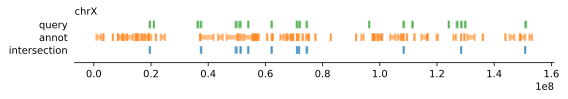

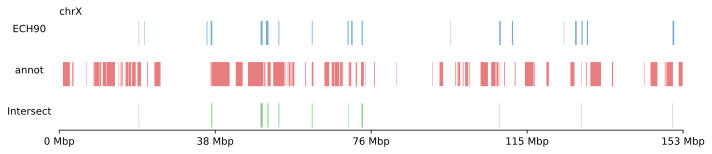

In [5]:

annot = dataframes['round_spermatid_100kb_arms']
query = ech90
intersect = interval_intersect(annot, query)

plot_intervals(query, annot, intersection=intersect)
plot_regions(query, annot, intersect)

Tests for round_spermatid_100kb_arms_smoothed
Proximity: TestResult(statistic=0.20566666666666641, pvalue=0.105)
Jaccard: 0.03319511172796144

Tests for round_spermatid_100kb_arms
Proximity: TestResult(statistic=0.49242857142857144, pvalue=0.0004)
Jaccard: 0.03916232332293147

Tests for round_spermatid_100kb_10Mb
Proximity: TestResult(statistic=0.3223076923076922, pvalue=0.0209)
Jaccard: 0.04512778341139746

Tests for round_spermatid_100kb_10Mb_smoothed
Proximity: TestResult(statistic=0.4658333333333337, pvalue=0.0017)
Jaccard: 0.04494391747197651



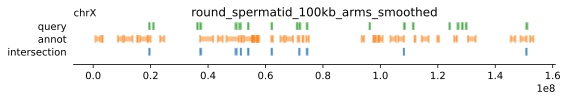

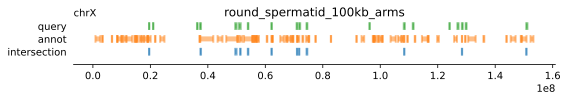

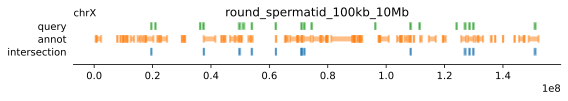

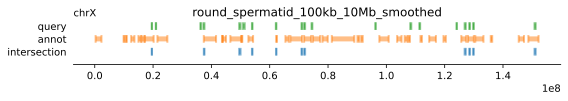

In [4]:
from genominterv import proximity_test, interval_collapse, interval_diff, interval_intersect, jaccard_stat

annot = dataframes['round_spermatid_100kb_arms']
query = ech90

#plot_intervals(query=query, annot=annot)

for key,annot in dataframes.items():
    # Filter out subset
    if ('round_spermatid_100') in key and not 'full' in key:
        # Plot the intervals
        intersection = interval_intersect(query, annot)
        plot_intervals(query=query, annot=annot, intersection=intersection)
        plt.title(key)

        # Do a proximity test
        print(f"Tests for {key}")
        annot_collapsed = interval_collapse(annot)
        non_ovl_query = interval_diff(query, annot_collapsed)
        print("Proximity:", proximity_test(non_ovl_query, annot_collapsed))
        print("Jaccard:", jaccard_stat(query, annot))
        print()



### Bootstrap to get a p-value

In [5]:
from genominterv import bootstrap

annot = dataframes['round_spermatid_100kb_arms']
chromsizes = (
    pd.read_csv('../data/rheMac10.filtered.chrom.sizes', 
                sep='\t', 
                index_col='chrom', 
                header=None, 
                names=['chrom','size'])
    .to_dict()['size']
)
#display(chromsizes)

@bootstrap(chromsizes, samples=1000)
def jaccard_bootstrap(query, annot):
    return jaccard_stat(query, annot)

jacccard_stat, p_value = jaccard_bootstrap(query, annot)

In [6]:
jacccard_stat, p_value

(0.03916232332293147, 0.31)

### Partition the A-compartments into regions *around* the edges 

In [7]:
df = dataframes['round_spermatid_100kb_arms']

start_edge = pd.DataFrame({
    'chrom': df['chrom'],
    'start': df['start']-1*df['resolution'],
    'end': df['start']+1*df['resolution'],
    'resolution': df['resolution'],
    'label': 'start_edge'
})
end_edge = pd.DataFrame({
    'chrom': df['chrom'],
    'start': df['end']-1*df['resolution'],
    'end': df['end']+1*df['resolution'],
    'resolution': df['resolution'],
    'label': 'end_edge'
})

#df
test_df = pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end'])
interval_collapse(test_df)

,start,end,chrom
0,800000,1000000,chrX
1,2500000,2700000,chrX
2,3100000,3300000,chrX
3,3400000,3600000,chrX
4,6500000,6800000,chrX
...,...,...,...
86,147000000,147200000,chrX
87,148800000,149400000,chrX
88,150800000,151000000,chrX
89,152200000,152400000,chrX


In [8]:
import os

for key, df in dataframes.items():
    outdir = '../results/edges'
    edge_csv_name = os.path.join(outdir,f'{key+'_edges.csv'}')
    if not os.path.exists(edge_csv_name):
        res = df['resolution'].unique()[0]

        start_edge = pd.DataFrame({
            'chrom': df['chrom'],
            'start': df['start']-1*df['resolution'],
            'end': df['start']+1*df['resolution'],
            'resolution': df['resolution'],
            'label': 'start_edge'
        })
        end_edge = pd.DataFrame({
            'chrom': df['chrom'],
            'start': df['end']-1*df['resolution'],
            'end': df['end']+1*df['resolution'],
            'resolution': df['resolution'],
            'label': 'end_edge'
        })

        if not os.path.exists(outdir):
            os.makedirs(outdir)

        tmp = pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end'])
        interval_collapse(tmp).assign(resolution=res).to_csv(edge_csv_name, index=False)

### Import edges

In [9]:
import pandas as pd
import os

# Directory containing your .csv files
csv_dir = '../results/edges/'

# Create a dictionary to store the DataFrames
edges = {}

# Iterate over all .csv files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):  # Check for .csv files
        # Construct the full file path
        filepath = os.path.join(csv_dir, filename)
        
        # Load the CSV into a DataFrame
        # Use the filename (without extension) as the dictionary key
        key = filename.replace('_edges_', '')
        key = os.path.splitext(key)[0]
        edges[key] = pd.read_csv(filepath)
        edges[key]['length'] = edges[key]['end'] - edges[key]['start']

# The `edges` dictionary now contains the DataFrames
print(edges.keys())
print(edges['fibroblast_100kb_10Mb_edges'].columns)

#ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')


dict_keys(['sperm_100kb_arms_smoothed_edges', 'spermatogonia_500kb_full_edges', 'pachytene_spermatocyte_100kb_10Mb_smoothed_edges', 'spermatogonia_100kb_arms_edges', 'fibroblast_500kb_full_edges', 'round_spermatid_500kb_10Mb_edges', 'fibroblast_100kb_arms_edges', 'spermatogonia_100kb_full_smoothed_edges', 'round_spermatid_100kb_full_smoothed_edges', 'round_spermatid_100kb_full_edges', 'fibroblast_100kb_10Mb_edges', 'round_spermatid_500kb_arms_edges', 'fibroblast_100kb_full_smoothed_edges', 'spermatogonia_100kb_10Mb_edges', 'sperm_500kb_arms_edges', 'spermatogonia_100kb_10Mb_smoothed_edges', 'sperm_100kb_full_edges', 'pachytene_spermatocyte_500kb_10Mb_edges', 'pachytene_spermatocyte_100kb_full_smoothed_edges', 'pachytene_spermatocyte_100kb_full_edges', 'pachytene_spermatocyte_500kb_arms_edges', 'fibroblast_100kb_10Mb_smoothed_edges', 'sperm_500kb_10Mb_edges', 'round_spermatid_100kb_10Mb_smoothed_edges', 'spermatogonia_500kb_arms_edges', 'spermatogonia_100kb_full_edges', 'spermatogonia_1

Text(0.5, 0.98, 'All edges')

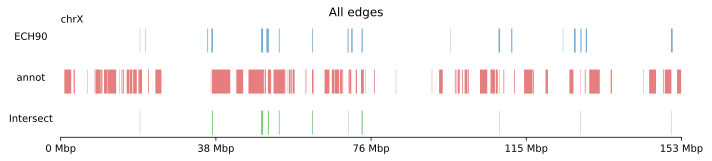

In [10]:
from genominterv import interval_intersect

sample = 'round_spermatid_100kb_arms'

full_df = dataframes[sample]
full_intersect = interval_intersect(full_df, ech90).assign(length=lambda x: x['end'] - x['start'])
edge_df = edges[f'{sample}_edges']

# Plot full
plot_regions(ech90, full_df, full_intersect)
plt.suptitle('All edges')

In [11]:
### Some stats about the data and intersections ###

# Determine the proportion of total regions in ECH90 that lies on compartment edges

print("Proportion of ECH90 on edges (#count)")

# Proportion of ECH90 on full regions
print(f'\t{full_intersect.shape[0] / ech90.shape[0]}')


print("\nProportion of ECH90 on edges (#bpairs)")

# Proportion of ECH90 on full regions
print(f'\t{full_intersect['length'].sum() / ech90['length'].sum()}')


# What is the total length of ech90 regions
print("\nTotal length of:")
print(f'\tECH90:  {(ech90['end'] - ech90['start']).sum()} bp')
print(f'\tEdges: {(edge_df["end"] - edge_df["start"]).sum()} bp')


Proportion of ECH90 on edges (#count)
	0.631578947368421

Proportion of ECH90 on edges (#bpairs)
	0.3932398045966063

Total length of:
	ECH90:  5511675 bp
	Edges: 28800000 bp


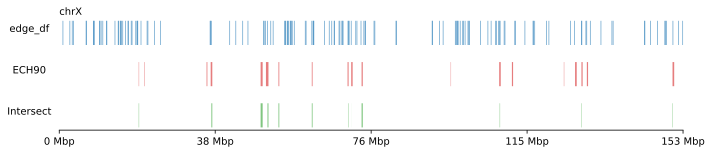

In [12]:
f, ax = plot_regions(edge_df, ech90, full_intersect)

for ax in list(f.axes):
    if ax.get_ylabel() == 'ECH90':
        ax.set_ylabel('edge_df', rotation=0, fontsize=10, labelpad=30)
    if ax.get_ylabel() == "query":
        ax.set_ylabel('ECH90', rotation=0, fontsize=10, labelpad=30)
    if ax.get_ylabel() == 'Intersect':
        #ax.set_ylabel('end_edge \nintersect', rotation=0, fontsize=10, labelpad=30)
        pass

        

### Do testing of the edges

In [16]:
%%capture
# Define what we are testing

print("""
Goal: To test whether ECH90 regions are enriched in compartment edges
Query: ECH90
Annotation: Start and end edges of compartments

Hypothesis: 
      ECH90 regions are enriched in compartment edges
Null hypothesis: 
      ECH90 regions are not enriched in compartment edges

Tests: 
* Proximity test: 
      tests whether the query regions are closer to 
      the annotation regions than expected by chance. 
      NB regions can not overlap, so we need to collapse the annotation regions

* Jaccard index: 
      tests the similarity between the query and annotation regions, 
      where a value of 1 indicates perfect overlap
""")

In [13]:
### Proximity test ###

from genominterv import proximity_test, interval_collapse, interval_diff, interval_intersect

# Define the query and annotation
query = ech90
annot = full_intersect

# Calculate the non-overlapping query regions
non_ovl_query_full = interval_diff(query, annot)

# Perform the proximity test
proximity_full = proximity_test(non_ovl_query_full, annot, two_sided=False)


print("Proximity test results: All edges")
print(f"\tstatistic: {proximity_full.statistic}, \n\tp-value: {proximity_full.pvalue}")


Proximity test results: All edges
	statistic: 0.6821666666666665, 
	p-value: 0.0


In [15]:
### Jaccard index ###

from genominterv import jaccard_stat, bootstrap

chromsizes = (pd.read_csv(
    '../data/rheMac10.filtered.chrom.sizes', 
    sep='\t', 
    index_col='chrom', 
    header=None, 
    names=['chrom','size'])
.to_dict()['size']
)

# # Calculate the Jaccard index
# jaccard_start = jaccard_stat(query, annot_start)
# jaccard_end = jaccard_stat(query, annot_end)
# jaccard_concat = jaccard_stat(query, annot_concat)

# print("\nJaccard index results")
# print(f"Start edge: {jaccard_start}")
# print(f"End edge: {jaccard_end}")
# print(f"Concat edge: {jaccard_concat}")

# Test with bootstrap decorator
@bootstrap(chromsizes, samples=1000)
def jaccard_bootstrap(query, annot):
    return jaccard_stat(query, annot)

jaccard_stat_full, p_value_full = jaccard_bootstrap(query,annot)

print(f"Jaccard index: {jaccard_stat_full}, p-value: {p_value_full}")


Jaccard index: 0.3932398045966063, p-value: 0.0


p-value is zero smaller than 0.001. Increase nr samples to get actual p-value.


### Check the length of the intervals

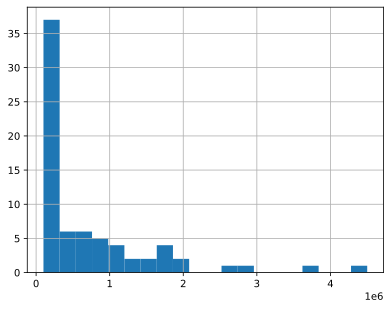

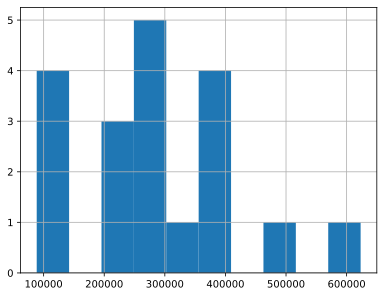

In [19]:
# Plot histogram of the lengths of the A compartments from the full regions

full_df['length'] = full_df['end'] - full_df['start']
full_df['length'].mean()

plt.figure()
full_df['length'].hist(bins=20)
plt.show()

plt.figure()
(ech90['end']-ech90['start']).hist(bins=10)
plt.show()

## Bioframe genomic intervals support


In [20]:
import bioframe 

## Geneinfo 

How does the edges align with genes?

This first plot is just to figure out how to plot with `gene_plot`.

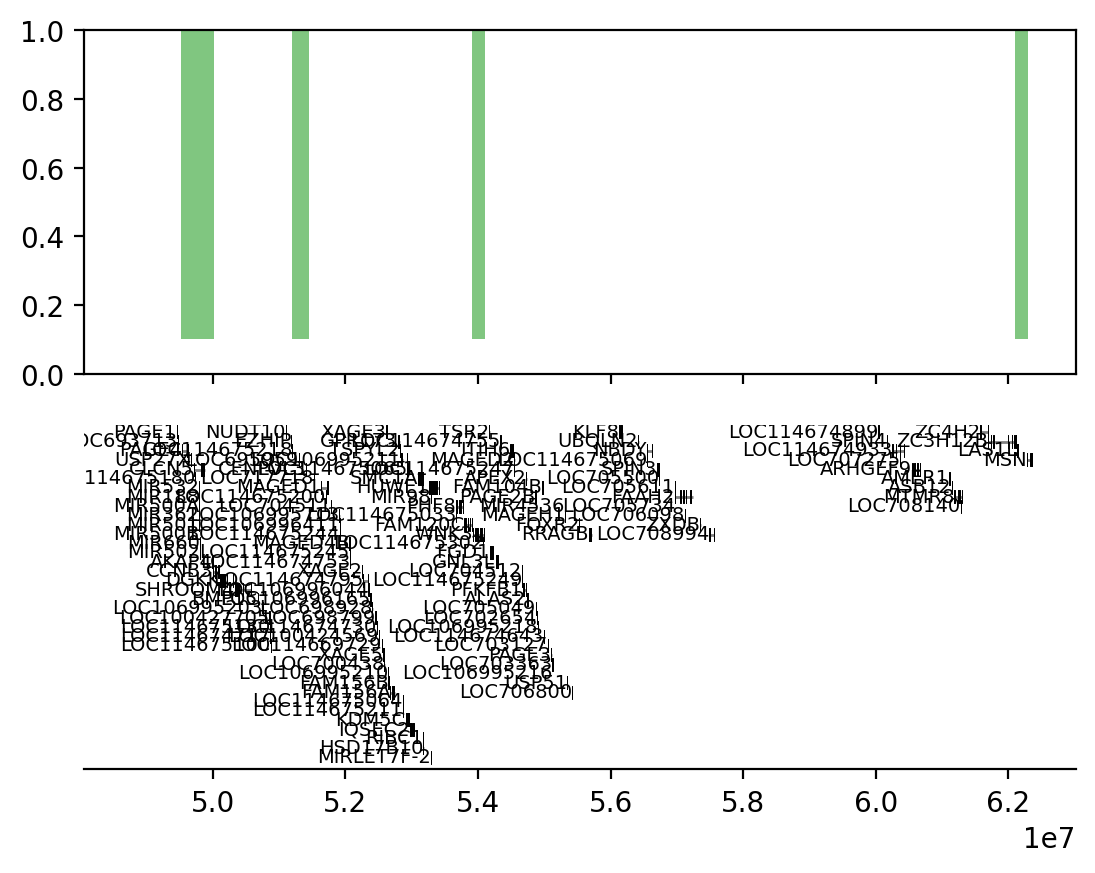

In [21]:
import geneinfo as gi
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


# Use the proximity test results to plot the ECH90 regions and the compartment edges

start = full_intersect['start'][2]
end = full_intersect['end'][5]

rectangles = [Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.6) for start, end in zip(full_intersect['start'][2:6], full_intersect['end'][2:6])]

pc = PatchCollection(rectangles, match_original=True)

ax = gi.gene_plot('chrX', start-100_000, end+100_000, assembly='rheMac10')
ax.add_collection(pc)

#### Get the geneinfo for all intersections between edges and ECH90

And write to a csv file. If the file exists, read it with pandas.

In [ ]:
# Use get_genes_region
import os.path as op
import geneinfo as gi
import pandas as pd

genes_file = '../results/edge_genes/rs_edges_100kb_genes.csv'

if not op.exists(genes_file):
    genes = pd.concat(
        full_intersect.apply(
            lambda x: gi.get_genes_region_dataframe('chrX', x['start'], x['end'], assembly='rheMac10'), 
            axis =1
            ).to_list(),
        ignore_index=True
    )
    genes.to_csv(genes_file, index=False) 
else: 
    genes = pd.read_csv(genes_file)

In [19]:
genes_list = genes['name'].unique().tolist()
genes_list

['SH3KBP1',
 'MIR7206',
 'LANCL3',
 'XK',
 'CYBB',
 'LOC696657',
 'DYNLT3',
 'PAGE4',
 'USP27X',
 'CLCN5',
 'LOC114675180',
 'MIR532',
 'MIR188',
 'MIR500A',
 'MIR362',
 'MIR501',
 'MIR500B',
 'MIR660',
 'MIR502',
 'AKAP4',
 'CCNB3',
 'LOC114675218',
 'LOC695959',
 'CENPVL3',
 'FAM120C',
 'WNK3',
 'LOC114675302',
 'ZC3H12B',
 'LAS1L',
 'MSN',
 'ATRX',
 'MAGT1',
 'LOC114675151',
 'COX7B',
 'ATP7A',
 'ALG13',
 'RAP2C',
 'DKC1',
 'LOC114675231',
 'MPP1',
 'SMIM9',
 'F8']

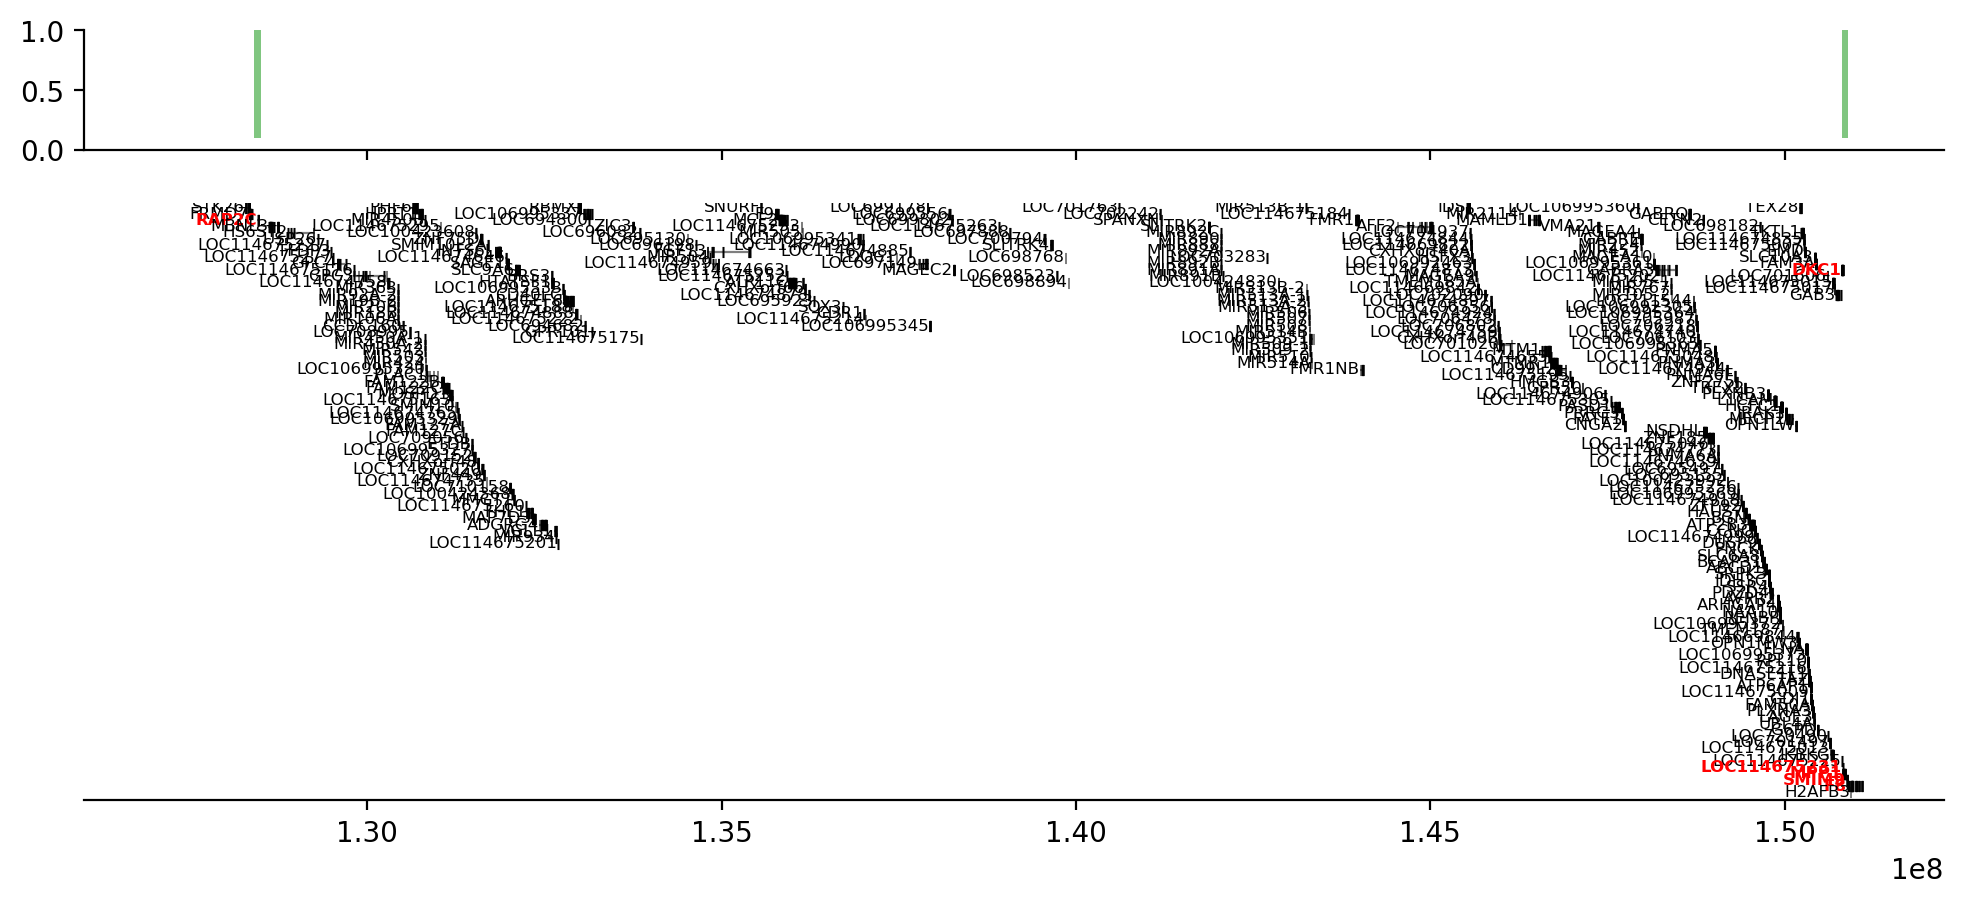

In [24]:
import geneinfo as gi
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


# Use the proximity test results to plot the ECH90 regions and the compartment edges

start_idx = 10
end_idx = 11

start = full_intersect['start'][start_idx]
end = full_intersect['end'][end_idx]

rectangles = [Rectangle(
    (start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.6) for start, end in zip(full_intersect['start'][start_idx:end_idx+1], full_intersect['end'][start_idx:end_idx+1])]

pc = PatchCollection(rectangles, match_original=True)

ax = gi.gene_plot('chrX', start-100_000, end+100_000, assembly='rheMac10', 
                  highlight=genes_list,
                  despine=True,
                  figsize=(12, 5),
                  aspect=5,
                  )
ax.add_collection(pc)

### What can I do with the list of genes on the edges?

#### GO enrichment?

In [25]:
mmul_x_genes = gi.get_genes_region_dataframe('chrX', 0, 155_000_000, assembly='rheMac10')

In [26]:
mmul_x_genelist = mmul_x_genes['name'].unique().tolist()

In [27]:
gene_list = genes['name'].unique().tolist()
taxid = 9544
gi.email('sojernj@gmail.com')
#gi.go_annotation_table(taxid=taxid)

#gi.show_go_evidence_codes()

go_terms = gi.get_go_terms_for_genes(gene_list, taxid=taxid)


In [29]:
len(go_terms)
#gene_list[:5]


98

In [31]:
results = gi.go_enrichment(
    gene_list[:5], 
    # Use human as a start
    alpha=0.05,
    terms=go_terms
    )

geneinfo_cache/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms; optional_attrs(def relationship)


Could not map gene symbol "MIR7206" to ncbi id
